<a href="https://colab.research.google.com/github/AmineHouari98/Unet_thyroid/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import os
import json
import logging
import sys
import random
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import xml.etree.ElementTree as ET
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from skimage import draw
from skimage import 


import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
#telechargement de la bdd
!wget http://cimalab.intec.co/applications/thyroid/thyroid.zip 
!mkdir thyroid # pour créer un répertoire nommé thyroid
!unzip thyroid.zip -d thyroid

In [2]:
#creation des dossiers
main_folder = '/content/thyroid/'
image_folder = '/content/thyroid/images/'
xml_folder = '/content/thyroid/xml/'
json_folder = '/content/thyroid/json/'
mask_folder = '/content/thyroid/masks/'
broken_folder = '/content/thyroid/broken/'

!mkdir /content/thyroid/masks/
!mkdir /content/thyroid/xml/
!mkdir /content/thyroid/json/
!mkdir /content/thyroid/broken/
!mkdir /content/thyroid/images/

#deplacer les xml et jpg dans les dossiers correspendant
for filename in os.listdir(main_folder):
  if filename.endswith('.xml'):
    shutil.move(main_folder+filename, xml_folder+filename)
  elif filename.endswith('.jpg'):
    shutil.move(main_folder+filename, image_folder+filename)

In [ ]:
#convertir les xml en json
for filename in os.listdir(xml_folder):
    context = ET.iterparse(xml_folder+filename, events=('end', ))
    print(filename)
    for event, elem in context:
        if elem.tag == 'mark':
            title = elem.find('image').text
            test = filename
            test = format(test.replace('.xml','_')+title+ ".json")
            data = elem.find('svg').text
            if not data: 
                continue
            else:
                with open(json_folder+test, 'w') as f:
                    f.write(data)
    

In [ ]:
#verifier la correspendance des images avec les masks

#retirer les images sans masque
for image in os.listdir(image_folder):
  img = image
  file = img.replace('jpg','json')
  if os.path.exists(json_folder+file):
    print(file+'_________________yes')
    continue
  else:
    print(file+'_________________no')
    shutil.move(image_folder+image, broken_folder+image)

#retirer les masques sans image
for json in os.listdir(json_folder):
  x = json
  file = x.replace('json','jpg')
  if os.path.exists(image_folder+file):
    print(file+'_________________yes')
    continue
  else:
    print(file+'_________________no')
    shutil.move(json_folder+json, broken_folder+json)





In [ ]:
#conversion des masques au format json au format png
logging.getLogger().setLevel(logging.INFO)


def move_broken_files(broken_json_name):
  test = broken_json_name
  json = broken_json_name
  image = test.replace('json','jpg')

  print(json)
  print(image)

  shutil.move(image_folder + image, broken_folder+image)
  shutil.move(json_folder + json, broken_folder+json)

def poly2mask(blobs, path_to_masks_folder, h, w,name):
    mask = np.zeros((h, w))
    for l in blobs:
        fill_row_coords, fill_col_coords = draw.polygon(l[1], l[0], l[2])
        mask[fill_row_coords, fill_col_coords] = 1
    io.imsave(path_to_masks_folder +name+".png", (mask*255).astype(np.uint8))


def convert_dataturks_to_masks(json_file, path_to_masks_folder,name):
    # make sure everything is setup.
    if (not os.path.isdir(path_to_masks_folder)):
        logging.exception(
             path_to_masks_folder + " doesn't exist")
        return
    if (not os.path.exists(json_folder+json_file)):
        logging.exception(
             path_to_masks_folder +json_file " doesn't exist")
        return

    f = open(json_folder+json_file)

    train_data = f.readlines()
    train = []
    for line in train_data:
        try:
          data = json.loads(line)
        except ValueError as e:
          print(json_file)
          move_broken_files(json_file) #si le fichier json est corrompu retirer l'image et le masque
          print('ERROR')
          continue
        train.append(data)
        #print(train)
    for objects in train:
        blobs = []
        classes = {}
        points = objects[0]['points']
        h = 360 
        w = 560 
        x_coord = []
        y_coord = []
        l = []
        for p in points:
          x_coord.append(p['x'])
          y_coord.append(p['y'])
        shape = (h, w)
        l.append(x_coord)
        l.append(y_coord)
        l.append(shape)
        blobs.append(l)
        poly2mask(blobs, path_to_masks_folder, h, w,name)



for filename in os.listdir(json_folder):
  if filename.endswith('.json'):
    print(filename)
    convert_dataturks_to_masks(filename, mask_folder,filename.replace('.json',''))

list = os.listdir(json_folder) # dir is your directory path
number_files = len(list)
print (number_files)

list2 = os.listdir(image_folder) # dir is your directory path
number_files2 = len(list2)
print (number_files2)



In [6]:
# initialisation de certains parametres
im_width = 256
im_height = 256
border = 5

In [7]:
ids = next(os.walk(image_folder))[2] # charger le nom de toutes les images
print("No. of images = ", len(ids))

No. of images =  466


In [8]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [11]:
# tqdm est utiliser pour afficher la bar de progression
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # redimentionner et charger les images
    img = load_img(image_folder+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_width, im_height, 1), mode = 'constant', preserve_range = True)
    # redimentionner et charger les masques
    mask = img_to_array(load_img(mask_folder+id_.replace('jpg','png'), grayscale=True))
    mask = resize(mask, (im_width, im_height, 1), mode = 'constant', preserve_range = True)
    # Normalisation et sauvegarde des masques et images
    X[n] = x_img/255.0
    y[n] = mask/255.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [12]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

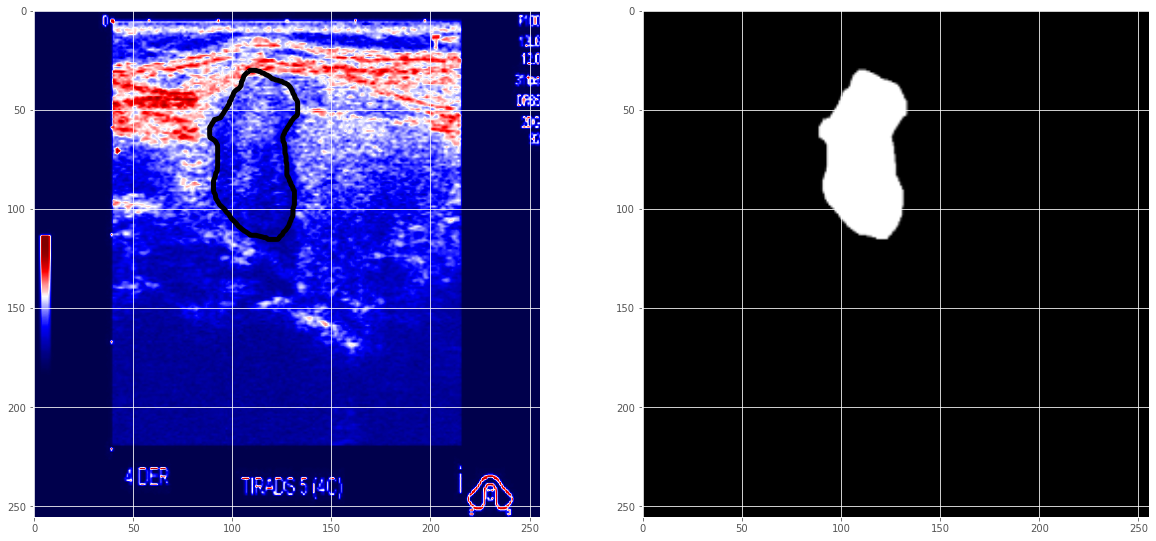

In [26]:
# Visualisation aleatoire d'une image et son masque
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])


ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')


In [20]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [21]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [22]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 16) 0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

In [24]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [25]:
results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/50
14/14 [==============================] - 196s 12s/step - loss: 0.5336 - accuracy: 0.8189 - val_loss: 0.5569 - val_accuracy: 0.9293

Epoch 00001: val_loss improved from inf to 0.55686, saving model to model-tgs-salt.h5
Epoch 2/50
14/14 [==============================] - 168s 12s/step - loss: 0.4077 - accuracy: 0.9204 - val_loss: 0.6694 - val_accuracy: 0.6678

Epoch 00002: val_loss did not improve from 0.55686
Epoch 3/50
14/14 [==============================] - 168s 12s/step - loss: 0.3377 - accuracy: 0.9237 - val_loss: 0.3361 - val_accuracy: 0.9382

Epoch 00003: val_loss improved from 0.55686 to 0.33613, saving model to model-tgs-salt.h5
Epoch 4/50
14/14 [==============================] - 169s 12s/step - loss: 0.2931 - accuracy: 0.9271 - val_loss: 0.2558 - val_accuracy: 0.9373

Epoch 00004: val_loss improved from 0.33613 to 0.25577, saving model to model-tgs-salt.h5
Epoch 5/50
14/14 [==============================] - 170s 12s/step - loss: 0.2666 - accuracy: 0.9259 - val_loss:

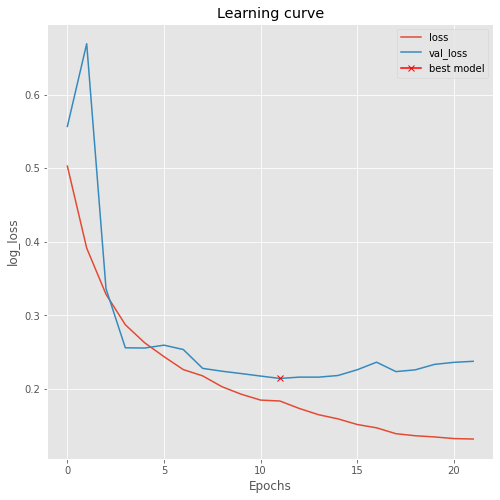

In [27]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [28]:
# load the best model
model.load_weights('model-tgs-salt.h5')

In [29]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

2/2 [==============================] - 4s 1s/step - loss: 0.2141 - accuracy: 0.9393


[0.21410587430000305, 0.9393430948257446]

In [30]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

2/2 [==============================] - 4s 1s/step


In [31]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [32]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Thyroid')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

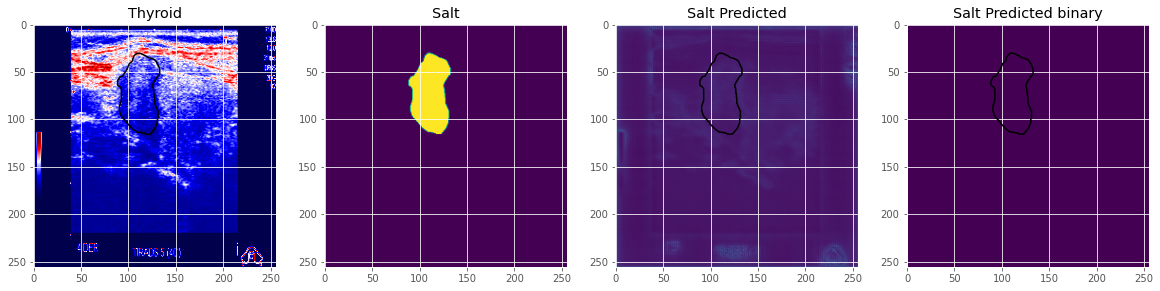

In [33]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

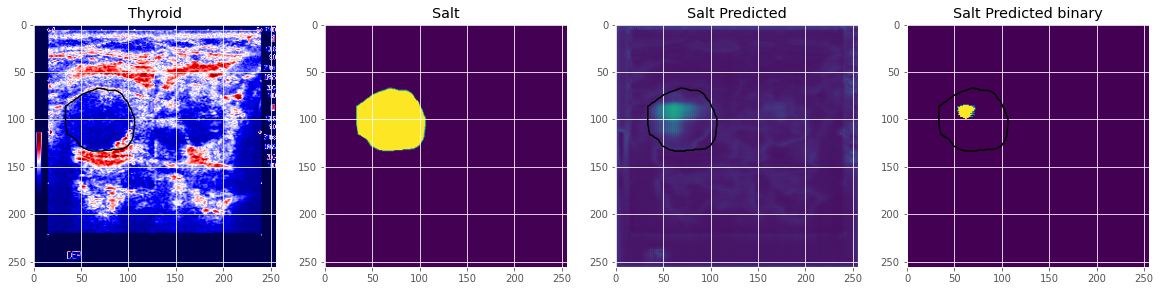

In [34]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

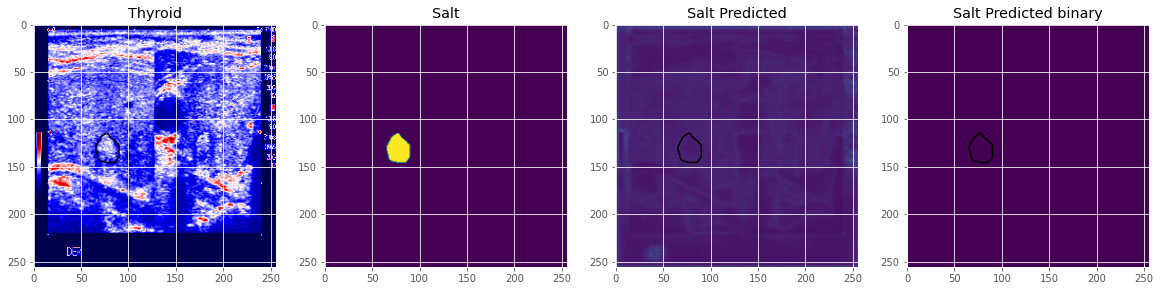

In [35]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

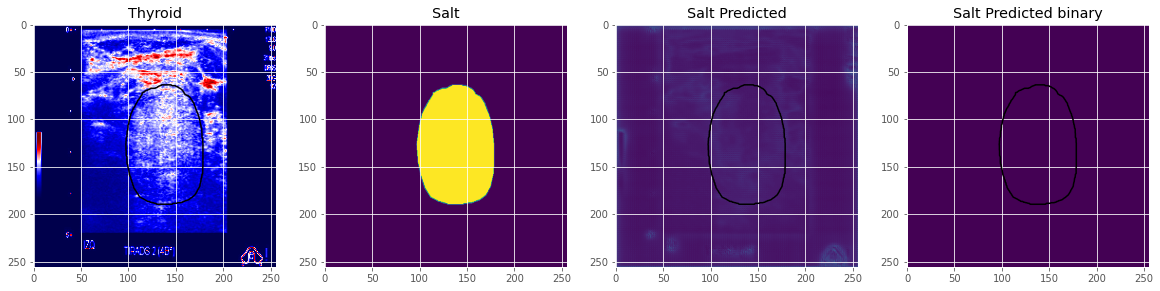

In [36]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

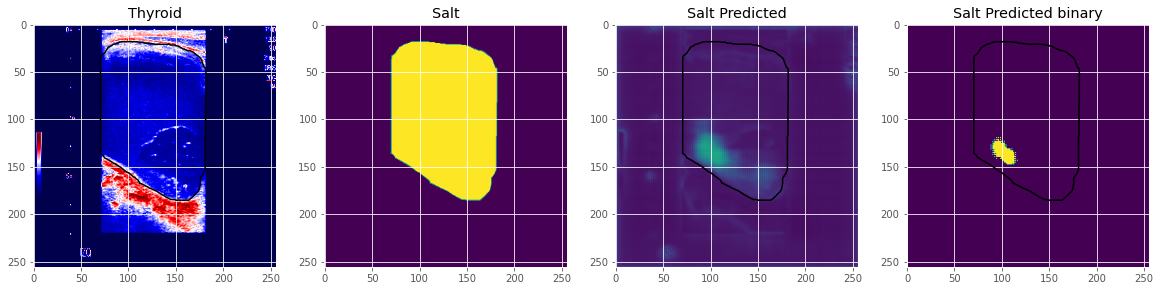

In [37]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

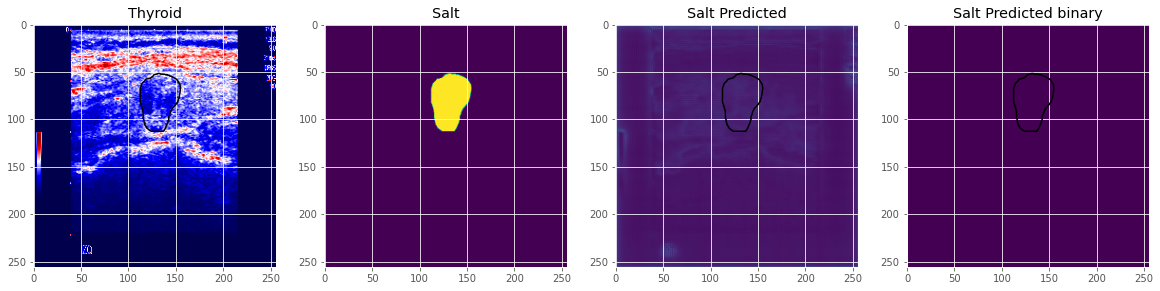

In [38]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

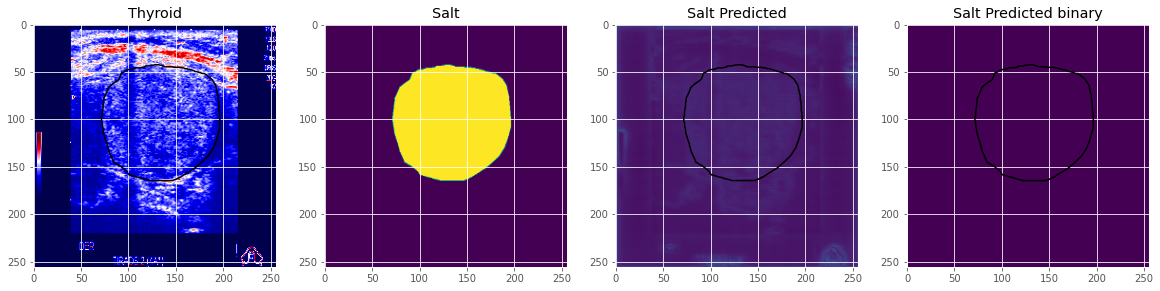

In [39]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

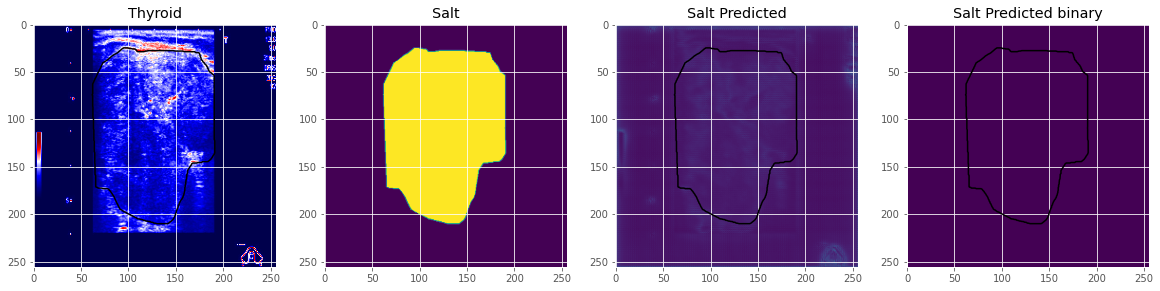

In [40]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

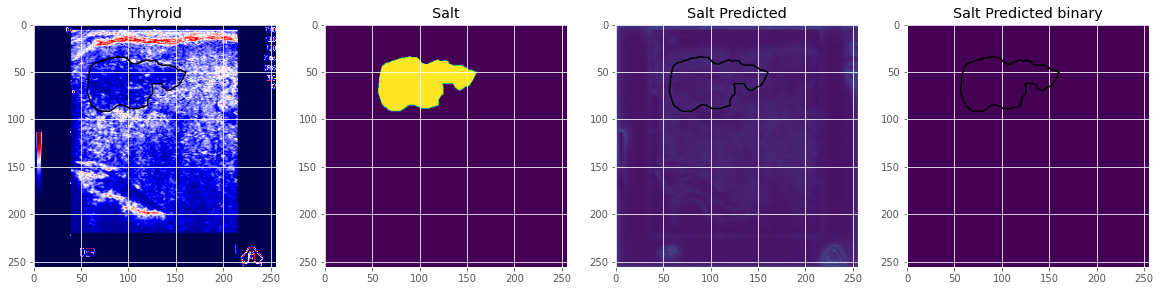

In [41]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

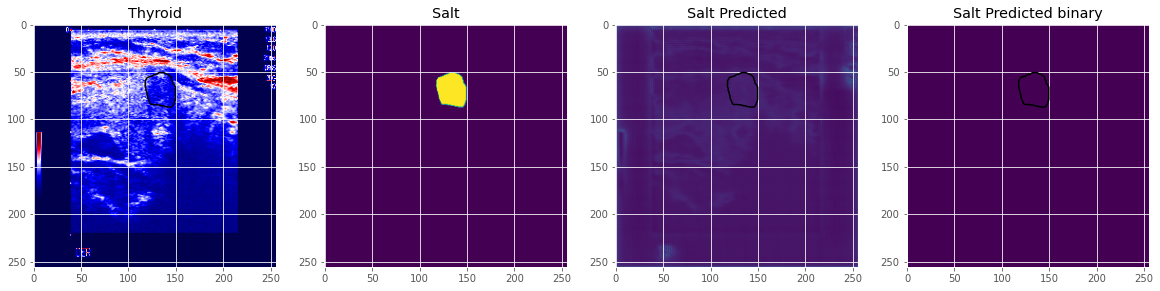

In [42]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=19)

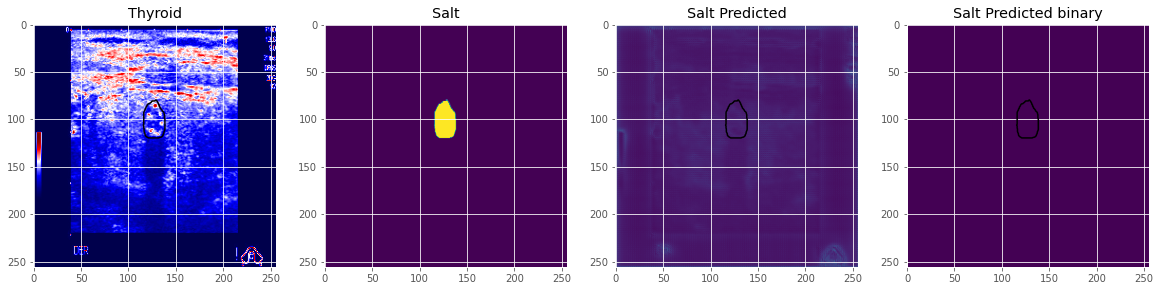

In [43]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

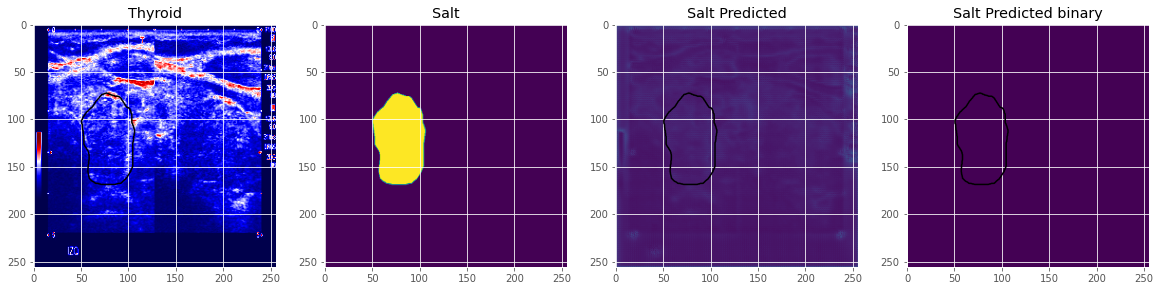

In [44]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

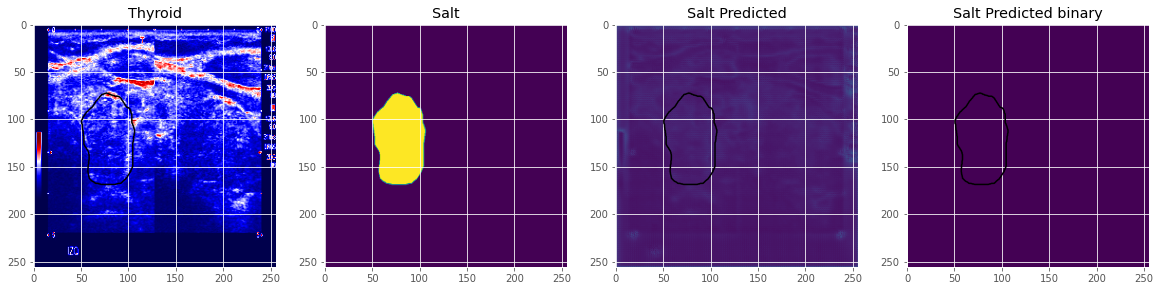

In [45]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

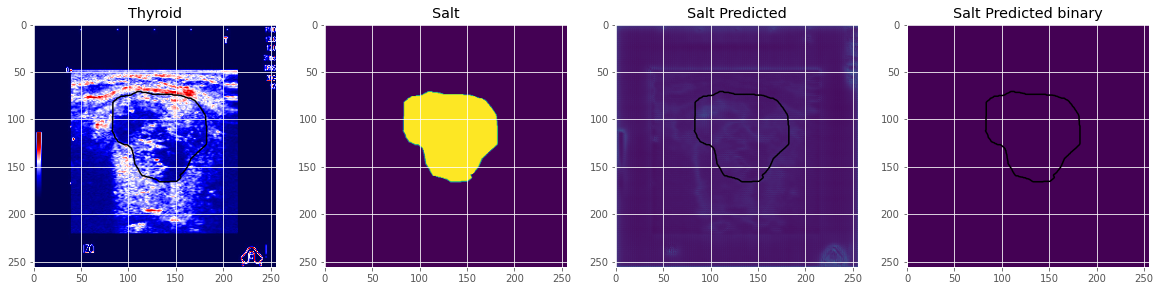

In [49]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)